In [276]:
import plotly.figure_factory as ff
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FuncFormatter

### Loading Datasets for GeoPanads, loan, and poverty information

In [277]:
# Load the loan dataset
df_loan = pd.read_csv(
    "https://raw.githubusercontent.com/wujenny214/Policy-Study-into-Grant-Assistance-for-Post-Hurricane-Rebuilding-Efforts/refs/heads/main/data/roadhome_for_datastore.csv"
)

df_loan = df_loan[df_loan["GIS State"] == "LA"]
df_loan = df_loan[df_loan["ARS File (Yes/No)"] == "N"]

/var/folders/xm/yhmrwng57qq9wlcywlm89pxh0000gn/T/ipykernel_56644/3987194667.py:2: DtypeWarning: Columns (13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_loan = pd.read_csv(


In [278]:
# Load SAIPE 2004 Louisiana county-level poverty data

colspecs = [
    (0, 2),  # 1-2   FIPS State
    (3, 6),  # 4-6   FIPS County
    # (7, 15),  # 8-15  Est all ages in poverty
    # (16, 24),  # 17-24 LCI
    # (25, 33),  # 26-33 UCI
    (34, 38),  # 35-38 % all ages est
    # (39, 43),  # 40-43 % all ages LCI
    # (44, 48),  # 45-48 % all ages UCI
    # (49, 57),  # 50-57 Est age 0-17
    # (58, 66),  # 59-66 LCI
    # (67, 75),  # 68-75 UCI
    # (76, 80),  # 77-80 % 0-17 est
    # (81, 85),  # 82-85 % 0-17 LCI
    # (86, 90),  # 87-90 % 0-17 UCI
    # (91, 99),  # 92-99 Est related children 5-17 in families
    # (100, 108),  # 101-108 LCI
    # (109, 117),  # 110-117 UCI
    # (118, 122),  # 119-122 % related 5-17 est
    # (123, 127),  # 124-127 % related 5-17 LCI
    # (128, 132),  # 129-132 % related 5-17 UCI
    # (133, 139),  # 134-139 Median HH income
    # (140, 146),  # 141-146 Median HH income LCI
    # (147, 153),  # 148-153 Median HH income UCI
    # (154, 161),  # Estimate of people under age 5 in poverty
    # (162, 169),  # 90% confidence interval lower bound of estimate of people under age 5 in poverty
    # (170, 177),  # 90% confidence interval upper bound of estimate of people under age 5 in poverty
    # (178, 182),  # Estimated percent of people under age 5 in poverty
    # (183, 187),  # 90% confidence interval lower bound of estimate of percent of people under age 5 in poverty
    # (189, 192),  # 90% confidence interval upper bound of estimate of percent of people under age 5 in poverty
    (193, 238),  # State or county name
    # (239, 241),  # Two-letter Postal State abbreviation
    # (242, 266),  # A tag indicating the file name and date of creation
]

names = [
    "state_fips",
    "county_fips",
    # "all_ages_pov_est",
    # "all_ages_pov_l",
    # "all_ages_pov_u",
    "all_ages_pov_pct_est",
    # "all_ages_pov_pct_l",
    # "all_ages_pov_pct_u",
    # "age0_17_pov_est",
    # "age0_17_pov_l",
    # "age0_17_pov_u",
    # "age0_17_pov_pct_est",
    # "age0_17_pov_pct_l",
    # "age0_17_pov_pct_u",
    # "rel5_17_pov_est",
    # "rel5_17_pov_l",
    # "rel5_17_pov_u",
    # "rel5_17_pov_pct_est",
    # "rel5_17_pov_pct_l",
    # "rel5_17_pov_pct_u",
    # "med_hh_income_est",
    # "med_hh_income_l",
    # "med_hh_income_u",
    # "est_ppl_under5pov",
    # "lci_ppl_under5pov",
    # "uci_ppl_under5pov",
    # "pct_ppl_under5pov_est",
    # "pct_ppl_under5pov_l",
    # "pct_ppl_under5pov_u",
    "parish",
    # "state",
    # "file_tag",
]

# Read the fixed-width file
url = "https://www2.census.gov/programs-surveys/saipe/datasets/2004/2004-state-and-county/est04-la.txt"
df_poverty = pd.read_fwf(url, colspecs=colspecs, names=names, dtype=str)

df_poverty

,state_fips,county_fips,all_ages_pov_pct_est,parish
0,22,0,19.2,Louisiana
1,22,1,21.0,Acadia Parish
2,22,3,22.0,Allen Parish
3,22,5,12.0,Ascension Parish
4,22,7,19.3,Assumption Parish
...,...,...,...,...
60,22,119,19.0,Webster Parish
61,22,121,16.8,West Baton Rouge Parish
62,22,123,22.7,West Carroll Parish
63,22,125,20.4,West Feliciana Parish


In [279]:
# # Construct the FIPS codes directly and save them into the dataframe
# df_poverty["FIPS"] = df_poverty.apply(
#     lambda row: row["state_fips"]
#     + ("00" if len(row["county_fips"]) == 1 else "0")
#     + row["county_fips"],
#     axis=1,
# )

# (ALT method) Initialize an empty list to store the FIPS codes
fips_codes = []

# Iterate through each row in the dataframe
for i, row in df_poverty.iterrows():
    # Check the length of the county_fips and construct the FIPS code accordingly
    if len(row["county_fips"]) == 1:
        fips_code = row["state_fips"] + "00" + row["county_fips"]
    elif len(row["county_fips"]) == 2:
        fips_code = row["state_fips"] + "0" + row["county_fips"]
    else:
        fips_code = row["state_fips"] + row["county_fips"]
    fips_codes.append(fips_code)

# Add the constructed FIPS codes as a new column in the dataframe
df_poverty["FIPS"] = fips_codes

df_poverty = df_poverty[["FIPS", "parish", "all_ages_pov_pct_est"]].copy()
df_poverty = df_poverty[1:]
df_poverty

,FIPS,parish,all_ages_pov_pct_est
1,22001,Acadia Parish,21.0
2,22003,Allen Parish,22.0
3,22005,Ascension Parish,12.0
4,22007,Assumption Parish,19.3
5,22009,Avoyelles Parish,24.8
...,...,...,...
60,22119,Webster Parish,19.0
61,22121,West Baton Rouge Parish,16.8
62,22123,West Carroll Parish,22.7
63,22125,West Feliciana Parish,20.4


### Plotting Louisiaina

,GEOID,STATEFP,COUNTYFP,NAME,geometry
103,22061,22,061,Lincoln,"POLYGON ((-92.88093 32.58526, -92.86661 32.607..."
392,22095,22,095,St. John the Baptist,"POLYGON ((-90.68727 30.0372, -90.66997 30.0476..."
409,22029,22,029,Concordia,"POLYGON ((-91.8633 31.35445, -91.84502 31.3759..."
570,22003,22,003,Allen,"POLYGON ((-93.13119 30.51828, -93.13081 30.564..."
628,22093,22,093,St. James,"POLYGON ((-90.96374 30.06683, -90.93559 30.085..."
...,...,...,...,...,...
3095,22083,22,083,Richland,"POLYGON ((-92.03117 32.2814, -92.01982 32.2976..."
3118,22037,22,037,East Feliciana,"POLYGON ((-91.32071 30.69942, -91.2931 30.7155..."
3126,22051,22,051,Jefferson,"POLYGON ((-90.28006 29.99171, -90.27986 29.998..."
3153,22049,22,049,Jackson,"POLYGON ((-92.81715 32.1617, -92.79882 32.1813..."


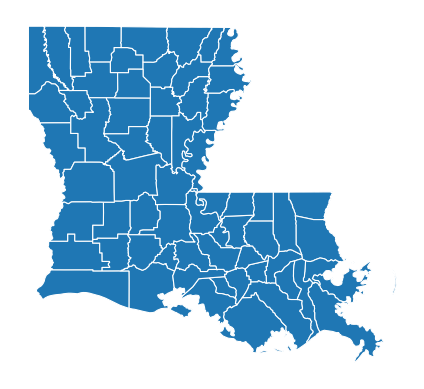

In [280]:
# Download all US counties (2023, 1:5m cartographic boundaries) from Census
url = "https://www2.census.gov/geo/tiger/GENZ2023/shp/cb_2023_us_county_5m.zip"
counties = gpd.read_file(url)

# Keep only Louisiana (STATEFP = '22')
la = counties[counties["STATEFP"] == "22"].copy()

# Keep useful fields; GEOID is the full 5-digit county/parish FIPS
la = la[["GEOID", "STATEFP", "COUNTYFP", "NAME", "geometry"]]

# Save as GeoJSON (Leaflet/Mapbox/Folium/Plotly-ready)
la.to_file("louisiana_counties_fips.geojson", driver="GeoJSON")

# Mapping Louisiana parishes
ax = la.plot(edgecolor="white", linewidth=0.8)
ax.set_axis_off()

la

In [281]:
# Concatenate the la dataframe with the df_poverty dataframe to include the geometry variable
df_poverty_with_geometry = pd.concat(
    [df_poverty.set_index("FIPS"), la.set_index("GEOID")[["geometry"]]],
    axis=1,
    join="inner",
).reset_index()

df_poverty_with_geometry

,index,parish,all_ages_pov_pct_est,geometry
0,22001,Acadia Parish,21.0,"POLYGON ((-92.63216 30.31429, -92.6195 30.3400..."
1,22003,Allen Parish,22.0,"POLYGON ((-93.13119 30.51828, -93.13081 30.564..."
2,22005,Ascension Parish,12.0,"POLYGON ((-91.10656 30.10852, -91.08983 30.108..."
3,22007,Assumption Parish,19.3,"POLYGON ((-91.25894 30.00067, -91.23635 30.000..."
4,22009,Avoyelles Parish,24.8,"POLYGON ((-92.28074 30.96507, -92.2086 30.9621..."
...,...,...,...,...
59,22119,Webster Parish,19.0,"POLYGON ((-93.51632 33.00254, -93.52099 33.018..."
60,22121,West Baton Rouge Parish,16.8,"POLYGON ((-91.48173 30.51103, -91.41482 30.511..."
61,22123,West Carroll Parish,22.7,"POLYGON ((-91.63888 32.70247, -91.61772 32.720..."
62,22125,West Feliciana Parish,20.4,"MULTIPOLYGON (((-91.66251 30.97036, -91.64877 ..."


In [282]:
import pandas as pd
import matplotlib.pyplot as plt

# Create bins manually
bins = [0, 5, 10, 15, 20, 25, 100]
labels = ["0–5%", "6–10%", "11–15%", "16–20%", "21–25%", "25%+"]

# Ensure the column is numeric before applying pd.cut
df_poverty_with_geometry["all_ages_pov_pct_est"] = pd.to_numeric(
    df_poverty_with_geometry["all_ages_pov_pct_est"], errors="coerce"
)

df_poverty_with_geometry["pov_bin"] = pd.cut(
    df_poverty_with_geometry["all_ages_pov_pct_est"],
    bins=bins,
    labels=labels,
    include_lowest=True,
)
df_poverty_with_geometry = gpd.GeoDataFrame(
    df_poverty_with_geometry, geometry="geometry", crs="EPSG:4269"
)
df_poverty_with_geometry

,index,parish,all_ages_pov_pct_est,geometry,pov_bin
0,22001,Acadia Parish,21.0,"POLYGON ((-92.63216 30.31429, -92.6195 30.3400...",21–25%
1,22003,Allen Parish,22.0,"POLYGON ((-93.13119 30.51828, -93.13081 30.564...",21–25%
2,22005,Ascension Parish,12.0,"POLYGON ((-91.10656 30.10852, -91.08983 30.108...",11–15%
3,22007,Assumption Parish,19.3,"POLYGON ((-91.25894 30.00067, -91.23635 30.000...",16–20%
4,22009,Avoyelles Parish,24.8,"POLYGON ((-92.28074 30.96507, -92.2086 30.9621...",21–25%
...,...,...,...,...,...
59,22119,Webster Parish,19.0,"POLYGON ((-93.51632 33.00254, -93.52099 33.018...",16–20%
60,22121,West Baton Rouge Parish,16.8,"POLYGON ((-91.48173 30.51103, -91.41482 30.511...",16–20%
61,22123,West Carroll Parish,22.7,"POLYGON ((-91.63888 32.70247, -91.61772 32.720...",21–25%
62,22125,West Feliciana Parish,20.4,"MULTIPOLYGON (((-91.66251 30.97036, -91.64877 ...",21–25%


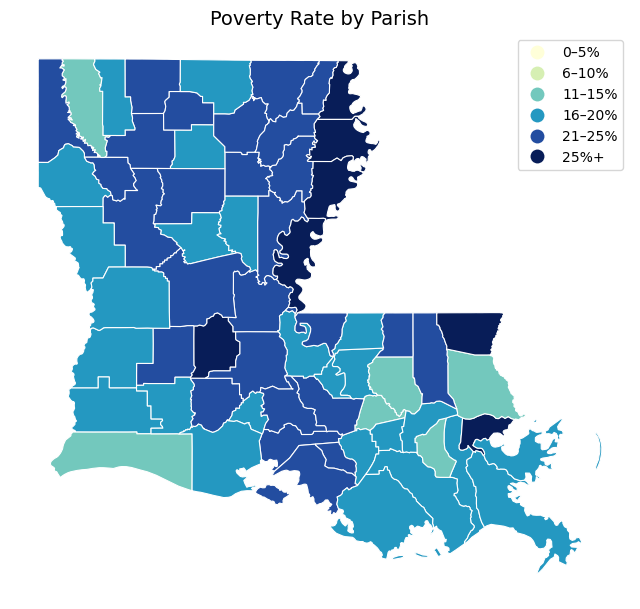

In [283]:
# Plot with grey for missing
fig, ax = plt.subplots(figsize=(8, 8))
df_poverty_with_geometry.plot(
    column="pov_bin",
    cmap="YlGnBu",
    linewidth=0.8,
    edgecolor="white",
    legend=True,
    ax=ax,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data",
    },
)
ax.set_title("Poverty Rate by Parish", fontsize=14)
ax.axis("off")
plt.show()

In [284]:
# To get accurate figures for the net grant amounts, the  difference between “current” (Current Total DOB Amount) and “closing” (Closing Total DOB Amount) DOB must
# be subtracted from the sum of the compensation and additional compensation grants (TOTAL_CLOSING_AMOUNT).

# Difference between “current” (Current Total DOB Amount) and “closing” (Closing Total DOB Amount) DOB
df_loan["delta"] = (
    df_loan["Current Total DOB Amount (no Legal Fees removed)"]
    - df_loan["Closing Total DOB Amount"]
)

# Calculate gross average loan amount
df_loan["gross_loan_amount"] = df_loan["TOTAL_CLOSING_AMOUNT"] - df_loan["delta"]

df_loan.head()

,Unnamed: 0,Structure Type,GIS City,GIS State,GIS Zip,PARISH,Closing Option,TOTAL_CLOSING_AMOUNT,Total CG Amount,Total ACG Amunt,...,PSV at Closing,"Closed file - PSV Option 1 With No ACG -excluding Sold Home, Inelig, Deceased and files closed with RHEI & IMM only -23,912","Closed File - Option 2/3, Sold Home, Ineligible, Deceased, and Closed with RHEI and IMM Only",Closed with Approved Unmet Needs (Y/N),Applicant With Current Insurance (Private and/or Flood) Y/N,Closing Total DOB Amount,Difference between Current PSV and Current Damage Assessment Type 2 (col AG - col AC,ARS File (Yes/No),delta,gross_loan_amount
0,9613.0,Single (including mobile home),METAIRIE,LA,70001,Jefferson,1.0,150000.00,95213.27,39036.73,...,172000.0,N,N,N,N,3772.04,-88818.13,N,0.0,150000.00
1,21349.0,Duplex (with one owner-occupied unit),METAIRIE,LA,70001,Jefferson,2.0,150000.00,150000.00,0.00,...,250000.0,N,Y,N,Y,57512.26,-250000.00,N,625.0,149375.00
2,25325.0,Duplex (with one owner-occupied unit),METAIRIE,LA,70001,Jefferson,1.0,3450.14,3450.14,0.00,...,240000.0,N,Y,N,Y,29741.00,-206808.86,N,0.0,3450.14
3,27236.0,Duplex (with one owner-occupied unit),METAIRIE,LA,70001,Jefferson,1.0,10665.59,10665.59,0.00,...,136000.0,N,N,N,Y,4824.55,-120509.86,N,0.0,10665.59
4,36177.0,Single (including mobile home),METAIRIE,LA,70001,Jefferson,1.0,131947.98,101947.98,0.00,...,345000.0,N,N,N,Y,75005.62,-345000.00,N,1166.4,130781.58


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


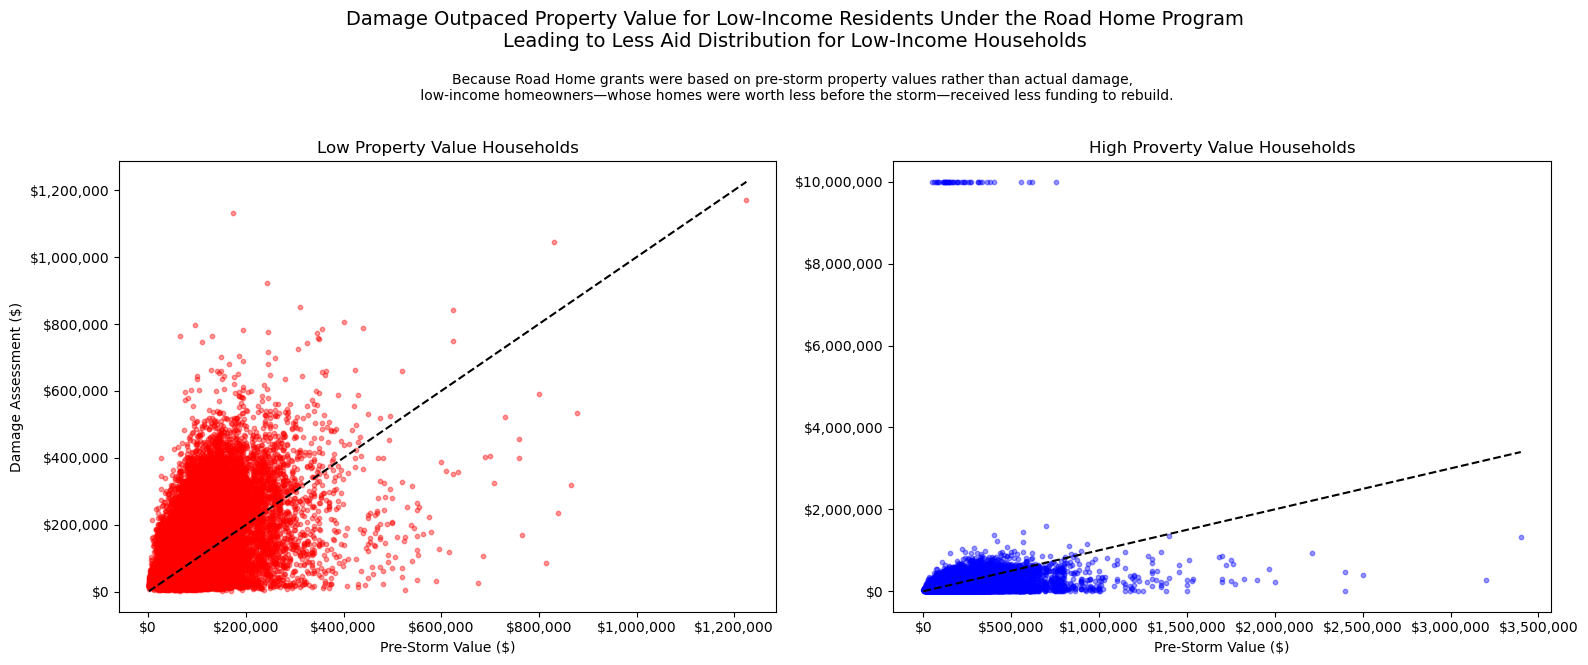

In [285]:
from matplotlib.ticker import FuncFormatter

# Filter the dataframe for Low Income rows
low_income_df = df_loan[df_loan["Total ACG Amunt"] > 0]

# Filter the dataframe for High Income rows
high_income_df = df_loan[df_loan["Total ACG Amunt"] == 0]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Define formatter for dollar amounts with commas
formatter = FuncFormatter(lambda x, _: f"${x:,.0f}")

# Plot Low Income dots
ax1.scatter(
    low_income_df["Current PSV"],
    low_income_df["Current Damage Assessment"],
    c="red",
    alpha=0.4,
    s=10,
)
ax1.plot(
    [low_income_df["Current PSV"].min(), low_income_df["Current PSV"].max()],
    [low_income_df["Current PSV"].min(), low_income_df["Current PSV"].max()],
    color="black",
    linestyle="--",
)
ax1.set_xlabel("Pre-Storm Value ($)")
ax1.set_ylabel("Damage Assessment ($)")
ax1.set_title("Low Property Value Households", fontsize=12)
ax1.xaxis.set_major_formatter(formatter)
ax1.yaxis.set_major_formatter(formatter)

# Plot High Income
ax2.scatter(
    high_income_df["Current PSV"],
    high_income_df["Current Damage Assessment"],
    c="blue",
    alpha=0.4,
    s=10,
)
ax2.plot(
    [high_income_df["Current PSV"].min(), high_income_df["Current PSV"].max()],
    [high_income_df["Current PSV"].min(), high_income_df["Current PSV"].max()],
    color="black",
    linestyle="--",
)
ax2.set_xlabel("Pre-Storm Value ($)")
ax2.set_title("High Proverty Value Households", fontsize=12)
ax2.xaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)

# Remove gridlines, legends, and extra text
ax1.grid(False)
ax2.grid(False)
ax1.legend().remove()
ax2.legend().remove()

fig.suptitle(
    "Damage Outpaced Property Value for Low-Income Residents Under the Road Home Program\nLeading to Less Aid Distribution for Low-Income Households",
    fontsize=14,
    y=1.1,
)
fig.text(
    0.5,
    0.95,
    "Because Road Home grants were based on pre-storm property values rather than actual damage, \n low-income homeowners—whose homes were worth less before the storm—received less funding to rebuild.",
    ha="center",
    fontsize=10,
)

# Simplify layout
plt.tight_layout()
plt.show()

In [286]:
# Ensure both columns have the same data type before merging
la["GEOID"] = la["GEOID"].astype(float)

# Merge loan data with geodataframe
df_loan_merged = la.merge(df_loan, left_on="GEOID", right_on="FIPS", how="left")
df_loan_merged = gpd.GeoDataFrame(df_loan_merged, geometry="geometry", crs="EPSG:4269")
df_loan_merged.head()

,GEOID,STATEFP,COUNTYFP,NAME,geometry,Unnamed: 0,Structure Type,GIS City,GIS State,GIS Zip,...,PSV at Closing,"Closed file - PSV Option 1 With No ACG -excluding Sold Home, Inelig, Deceased and files closed with RHEI & IMM only -23,912","Closed File - Option 2/3, Sold Home, Ineligible, Deceased, and Closed with RHEI and IMM Only",Closed with Approved Unmet Needs (Y/N),Applicant With Current Insurance (Private and/or Flood) Y/N,Closing Total DOB Amount,Difference between Current PSV and Current Damage Assessment Type 2 (col AG - col AC,ARS File (Yes/No),delta,gross_loan_amount
0,22061.0,22,061,Lincoln,"POLYGON ((-92.88093 32.58526, -92.86661 32.607...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,22095.0,22,095,St. John the Baptist,"POLYGON ((-90.68727 30.0372, -90.66997 30.0476...",25172.0,Single (including mobile home),EDGARD,LA,70049,...,35000.00,N,N,N,N,4722.53,-35000.00,N,0.0,150000.00
2,22095.0,22,095,St. John the Baptist,"POLYGON ((-90.68727 30.0372, -90.66997 30.0476...",63448.0,Mobile Home on Leased Land,EDGARD,LA,70049,...,13698.99,N,N,N,N,3783.24,-13698.99,N,0.0,26666.76
3,22095.0,22,095,St. John the Baptist,"POLYGON ((-90.68727 30.0372, -90.66997 30.0476...",74986.0,Mobile Home on Leased Land,WALLACE,LA,70049,...,7772.46,N,N,N,N,2325.80,-7772.46,N,0.0,31554.20
4,22095.0,22,095,St. John the Baptist,"POLYGON ((-90.68727 30.0372, -90.66997 30.0476...",76398.0,Mobile Home,EDGARD,LA,70049,...,47857.94,N,N,N,N,0.00,-47857.94,N,0.0,31559.00


In [287]:
df_loan_merged_avg = (
    df_loan_merged.groupby(["GEOID", "NAME"], dropna=False)[
        ["gross_loan_amount", "Current PSV"]
    ]
    .mean()
    .reset_index()
)
df_loan_merged_avg

,GEOID,NAME,gross_loan_amount,Current PSV
0,22001.0,Acadia,40621.483483,53721.343146
1,22003.0,Allen,35598.139412,55756.601597
2,22005.0,Ascension,45610.498978,65455.577518
3,22007.0,Assumption,35484.623284,36460.792985
4,22009.0,Avoyelles,NaN,NaN
...,...,...,...,...
59,22119.0,Webster,NaN,NaN
60,22121.0,West Baton Rouge,49890.044000,74416.250000
61,22123.0,West Carroll,NaN,NaN
62,22125.0,West Feliciana,59033.690000,47750.000000


In [288]:
# merge average loan amounts back to geodataframe
df_loan_geo = la.merge(
    df_loan_merged_avg, left_on="GEOID", right_on="GEOID", how="left"
)

df_loan_geo = gpd.GeoDataFrame(df_loan_geo, geometry="geometry", crs="EPSG:4326")
df_loan_geo

,GEOID,STATEFP,COUNTYFP,NAME_x,geometry,NAME_y,gross_loan_amount,Current PSV
0,22061.0,22,061,Lincoln,"POLYGON ((-92.88093 32.58526, -92.86661 32.607...",Lincoln,NaN,NaN
1,22095.0,22,095,St. John the Baptist,"POLYGON ((-90.68727 30.0372, -90.66997 30.0476...",St. John the Baptist,29080.760026,89059.230702
2,22029.0,22,029,Concordia,"POLYGON ((-91.8633 31.35445, -91.84502 31.3759...",Concordia,NaN,NaN
3,22003.0,22,003,Allen,"POLYGON ((-93.13119 30.51828, -93.13081 30.564...",Allen,35598.139412,55756.601597
4,22093.0,22,093,St. James,"POLYGON ((-90.96374 30.06683, -90.93559 30.085...",St. James,36335.596821,58766.431156
...,...,...,...,...,...,...,...,...
59,22083.0,22,083,Richland,"POLYGON ((-92.03117 32.2814, -92.01982 32.2976...",Richland,NaN,NaN
60,22037.0,22,037,East Feliciana,"POLYGON ((-91.32071 30.69942, -91.2931 30.7155...",East Feliciana,32922.627826,54314.186522
61,22051.0,22,051,Jefferson,"POLYGON ((-90.28006 29.99171, -90.27986 29.998...",Jefferson,55821.098659,158116.792465
62,22049.0,22,049,Jackson,"POLYGON ((-92.81715 32.1617, -92.79882 32.1813...",Jackson,NaN,NaN


Text(0.5, 1.0, 'Average Total Closing Amount by Parish')

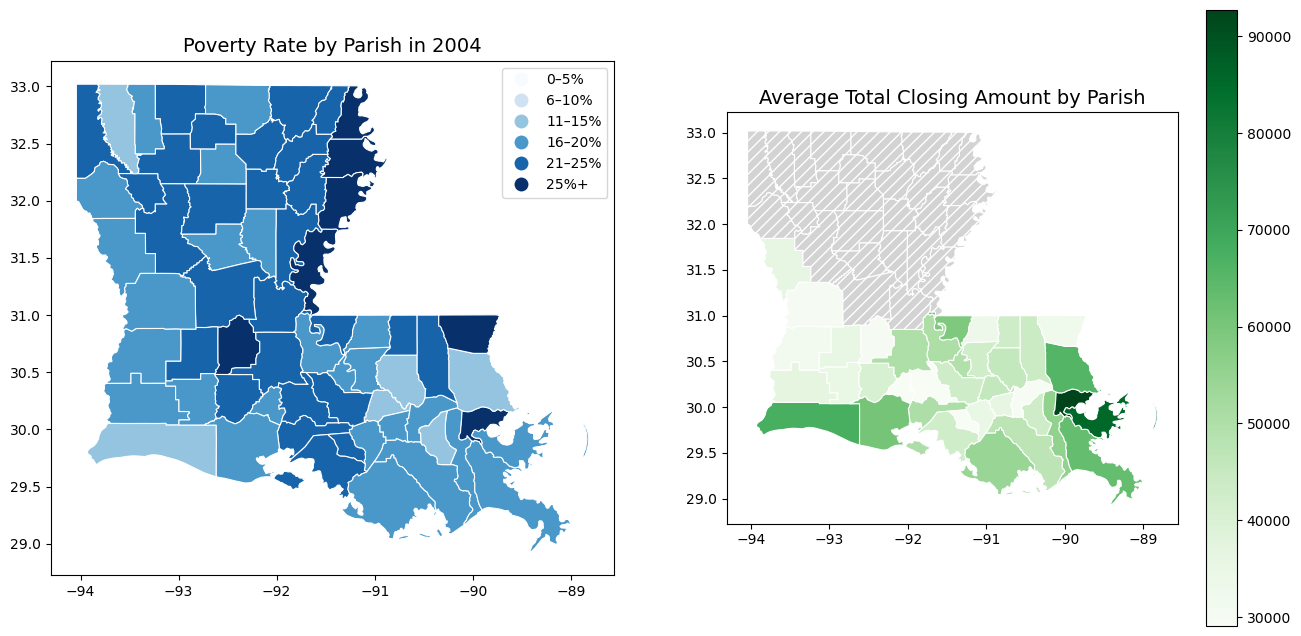

In [289]:
# plotting Poverty Rate by Parish in 2004 next to Average Gross Loan Amount by Parish
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
df_poverty_with_geometry.plot(
    column="pov_bin",
    cmap="Blues",
    linewidth=0.8,
    edgecolor="white",
    legend=True,
    ax=ax1,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data",
    },
)
ax1.set_title("Poverty Rate by Parish in 2004", fontsize=14)

df_loan_ttl_merged_avg = (
    df_loan_merged.groupby(["GEOID", "NAME"], dropna=False)["TOTAL_CLOSING_AMOUNT"]
    .mean()
    .reset_index()
)

df_loan_ttl_merged_avg = pd.concat(
    [df_loan_ttl_merged_avg.set_index("GEOID"), la.set_index("GEOID")[["geometry"]]],
    axis=1,
    join="inner",
).reset_index()

df_loan_ttl_merged_avg = gpd.GeoDataFrame(
    df_loan_ttl_merged_avg, geometry="geometry", crs="EPSG:4269"
)

df_loan_ttl_merged_avg.plot(
    column="TOTAL_CLOSING_AMOUNT",
    cmap="Greens",
    linewidth=0.8,
    edgecolor="white",
    legend=True,
    ax=ax2,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data",
    },
)
ax2.set_title("Average Total Closing Amount by Parish", fontsize=14)

Text(0.5, 1.0, 'Average Gross Loan Amount by Parish')

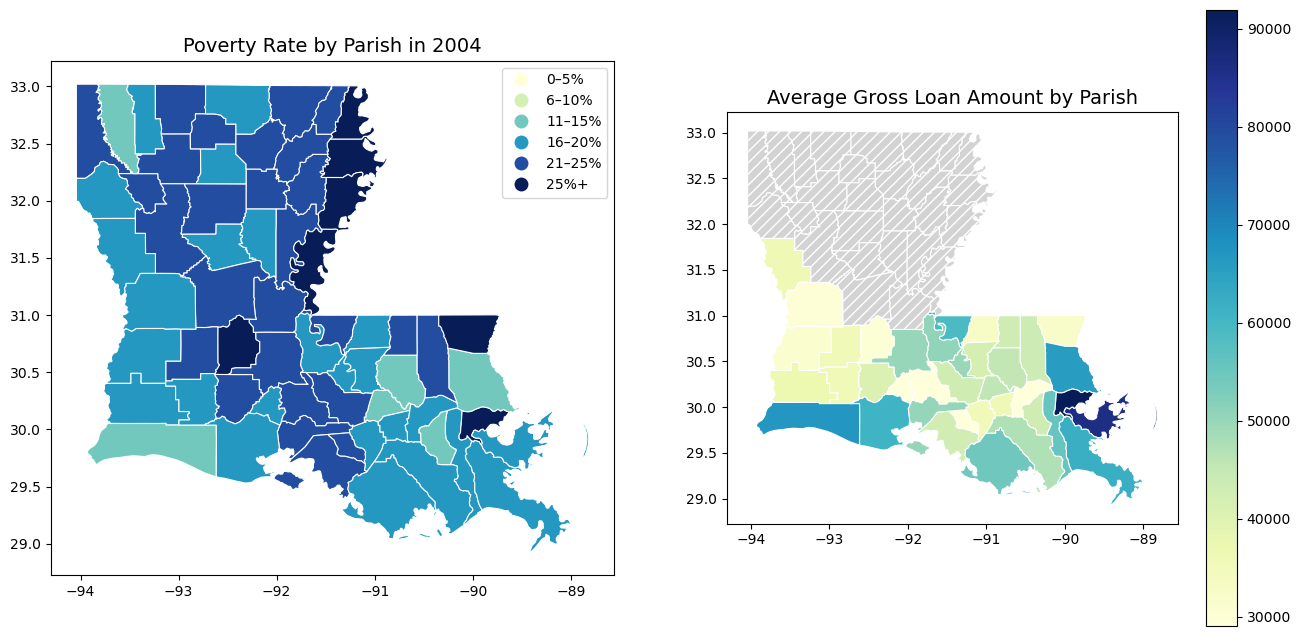

In [290]:
# plotting Poverty Rate by Parish in 2004 next to total loan amount by Parish
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
df_poverty_with_geometry.plot(
    column="pov_bin",
    cmap="YlGnBu",
    linewidth=0.8,
    edgecolor="white",
    legend=True,
    ax=ax1,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data",
    },
)
ax1.set_title("Poverty Rate by Parish in 2004", fontsize=14)

df_loan_geo.plot(
    column="gross_loan_amount",
    cmap="YlGnBu",
    linewidth=0.8,
    edgecolor="white",
    legend=True,
    ax=ax2,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data",
    },
)
ax2.set_title("Average Gross Loan Amount by Parish", fontsize=14)

In [291]:
# Ensure both columns have the same data type before merging
df_poverty_with_geometry["index"] = df_poverty_with_geometry["index"].astype(int)

# Merge df_loan_geo and df_poverty_with_geometry on GEOID to create a combined dataframe
df_combined = df_loan_geo.merge(
    df_poverty_with_geometry[["index", "pov_bin", "all_ages_pov_pct_est"]],
    left_on="GEOID",
    right_on="index",
    how="right",
)
df_combined

,GEOID,STATEFP,COUNTYFP,NAME_x,geometry,NAME_y,gross_loan_amount,Current PSV,index,pov_bin,all_ages_pov_pct_est
0,22001.0,22,001,Acadia,"POLYGON ((-92.63216 30.31429, -92.6195 30.3400...",Acadia,40621.483483,53721.343146,22001,21–25%,21.0
1,22003.0,22,003,Allen,"POLYGON ((-93.13119 30.51828, -93.13081 30.564...",Allen,35598.139412,55756.601597,22003,21–25%,22.0
2,22005.0,22,005,Ascension,"POLYGON ((-91.10656 30.10852, -91.08983 30.108...",Ascension,45610.498978,65455.577518,22005,11–15%,12.0
3,22007.0,22,007,Assumption,"POLYGON ((-91.25894 30.00067, -91.23635 30.000...",Assumption,35484.623284,36460.792985,22007,16–20%,19.3
4,22009.0,22,009,Avoyelles,"POLYGON ((-92.28074 30.96507, -92.2086 30.9621...",Avoyelles,NaN,NaN,22009,21–25%,24.8
...,...,...,...,...,...,...,...,...,...,...,...
59,22119.0,22,119,Webster,"POLYGON ((-93.51632 33.00254, -93.52099 33.018...",Webster,NaN,NaN,22119,16–20%,19.0
60,22121.0,22,121,West Baton Rouge,"POLYGON ((-91.48173 30.51103, -91.41482 30.511...",West Baton Rouge,49890.044000,74416.250000,22121,16–20%,16.8
61,22123.0,22,123,West Carroll,"POLYGON ((-91.63888 32.70247, -91.61772 32.720...",West Carroll,NaN,NaN,22123,21–25%,22.7
62,22125.0,22,125,West Feliciana,"MULTIPOLYGON (((-91.66251 30.97036, -91.64877 ...",West Feliciana,59033.690000,47750.000000,22125,21–25%,20.4


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


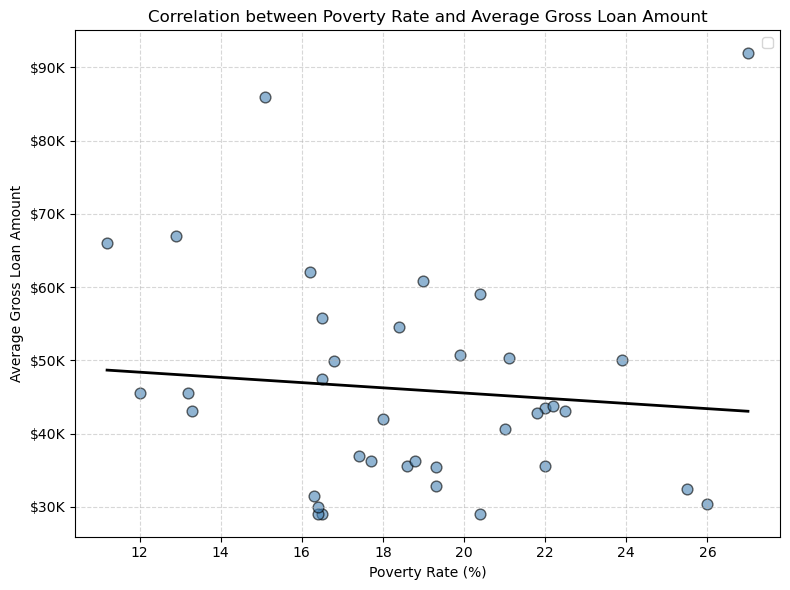

Slope: -355.6882
Intercept: 52665.7411


In [292]:
from matplotlib.ticker import FuncFormatter

df_clean = df_combined.dropna(
    subset=["all_ages_pov_pct_est", "gross_loan_amount"]
).copy()

# Extract x and y
x = df_clean["all_ages_pov_pct_est"].values.reshape(-1, 1)
y = df_clean["gross_loan_amount"].values

# Fit linear regression
model = LinearRegression()
model.fit(x, y)

# Predict regression line
x_range = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
y_pred = model.predict(x_range)

# --- Plotting ---
plt.figure(figsize=(8, 6))

# Scatter plot
plt.scatter(
    df_clean["all_ages_pov_pct_est"],
    df_clean["gross_loan_amount"],
    alpha=0.6,
    color="steelblue",
    s=60,
    edgecolor="black",
)

# Regression line
plt.plot(x_range, y_pred, color="black", linewidth=2)

# Format y-axis in thousands
formatter = FuncFormatter(lambda x, _: f"${x/1000:,.0f}K")
plt.gca().yaxis.set_major_formatter(formatter)

# Labels and styling
plt.title("Correlation between Poverty Rate and Average Gross Loan Amount")
plt.xlabel("Poverty Rate (%)")
plt.ylabel("Average Gross Loan Amount")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Regression stats
print(f"Slope: {model.coef_[0]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


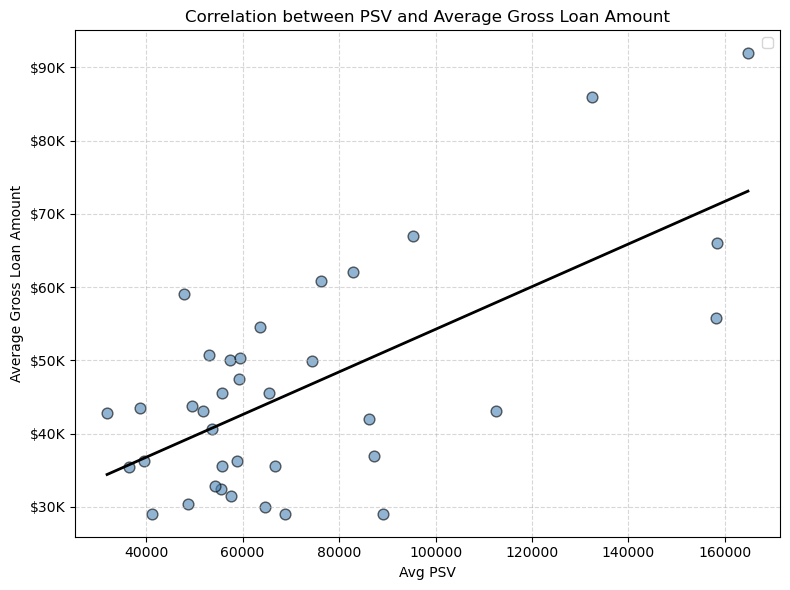

Slope: 0.2911
Intercept: 25148.5683


In [293]:
from matplotlib.ticker import FuncFormatter


# Extract x and y
df_loan_geo = df_loan_geo.dropna(subset=["Current PSV", "gross_loan_amount"]).copy()
x = df_loan_geo["Current PSV"].values.reshape(-1, 1)
y = df_loan_geo["gross_loan_amount"].values

# Fit linear regression
model = LinearRegression()
model.fit(x, y)

# Predict regression line
x_range = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
y_pred = model.predict(x_range)

# --- Plotting ---
plt.figure(figsize=(8, 6))

# Scatter plot
plt.scatter(
    df_loan_geo["Current PSV"],
    df_loan_geo["gross_loan_amount"],
    alpha=0.6,
    color="steelblue",
    s=60,
    edgecolor="black",
)

# Regression line
plt.plot(x_range, y_pred, color="black", linewidth=2)

# Format y-axis in thousands
formatter = FuncFormatter(lambda x, _: f"${x/1000:,.0f}K")
plt.gca().yaxis.set_major_formatter(formatter)

# Labels and styling
plt.title("Correlation between PSV and Average Gross Loan Amount")
plt.xlabel("Avg PSV")
plt.ylabel("Average Gross Loan Amount")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Regression stats
print(f"Slope: {model.coef_[0]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")

### Plotting counts of loans by parish

<Axes: >

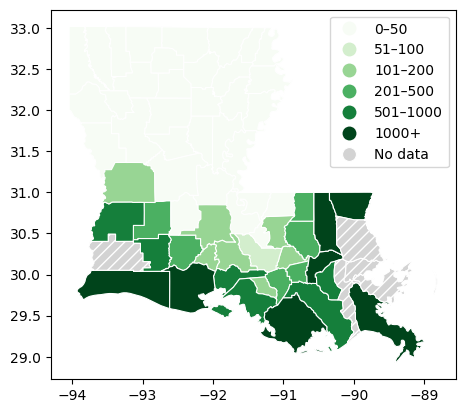

In [294]:
df_loan_merged_count = (
    df_loan_merged.groupby(["GEOID", "geometry", "PARISH"], dropna=False)
    .size()
    .reset_index(name="count")
)
df_loan_merged_count = gpd.GeoDataFrame(
    df_loan_merged_count, geometry="geometry", crs="EPSG:4269"
)
df_loan_merged_count

# Create new bins for better grouping
bins = [0, 50, 100, 200, 500, 1000, 5000]
labels = ["0–50", "51–100", "101–200", "201–500", "501–1000", "1000+"]

# Add a new column for the bins
df_loan_merged_count["count_bin"] = pd.cut(
    df_loan_merged_count["count"], bins=bins, labels=labels, include_lowest=True
)

# Plot with the new bins
df_loan_merged_count.plot(
    column="count_bin",
    cmap="Greens",
    linewidth=0.8,
    edgecolor="white",
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data",
    },
)

In [295]:
df_loan_merged["ratio"] = (
    df_loan_merged["Total CG Amount"] / df_loan_merged["Current Damage Assessment"]
)

df_loan_merged_ratio_avg = (
    df_loan_merged.groupby(["GEOID", "NAME", "geometry"], dropna=False)["ratio"]
    .mean()
    .reset_index()
)
df_loan_merged_ratio_avg = gpd.GeoDataFrame(
    df_loan_merged_ratio_avg, geometry="geometry", crs="EPSG:4269"
)
df_loan_merged_ratio_avg

,GEOID,NAME,geometry,ratio
0,22001.0,Acadia,"POLYGON ((-92.63216 30.31429, -92.6195 30.3400...",0.521272
1,22003.0,Allen,"POLYGON ((-93.13119 30.51828, -93.13081 30.564...",0.524161
2,22005.0,Ascension,"POLYGON ((-91.10656 30.10852, -91.08983 30.108...",0.525840
3,22007.0,Assumption,"POLYGON ((-91.25894 30.00067, -91.23635 30.000...",0.434855
4,22009.0,Avoyelles,"POLYGON ((-92.28074 30.96507, -92.2086 30.9621...",NaN
...,...,...,...,...
59,22119.0,Webster,"POLYGON ((-93.51632 33.00254, -93.52099 33.018...",NaN
60,22121.0,West Baton Rouge,"POLYGON ((-91.48173 30.51103, -91.41482 30.511...",0.528340
61,22123.0,West Carroll,"POLYGON ((-91.63888 32.70247, -91.61772 32.720...",NaN
62,22125.0,West Feliciana,"MULTIPOLYGON (((-91.66251 30.97036, -91.64877 ...",0.435584


In [296]:
# merge df_loan_merged_ratio_avg and df_poverty on GEOID to create a combined dataframe
df_poverty["FIPS"] = df_poverty["FIPS"].astype(int)

df_loan_merged_ratio_avg_1 = df_loan_merged_ratio_avg.merge(
    df_poverty[["FIPS", "all_ages_pov_pct_est"]],
    left_on="GEOID",
    right_on="FIPS",
    how="right",
)

df_loan_merged_ratio_avg_1

,GEOID,NAME,geometry,ratio,FIPS,all_ages_pov_pct_est
0,22001.0,Acadia,"POLYGON ((-92.63216 30.31429, -92.6195 30.3400...",0.521272,22001,21.0
1,22003.0,Allen,"POLYGON ((-93.13119 30.51828, -93.13081 30.564...",0.524161,22003,22.0
2,22005.0,Ascension,"POLYGON ((-91.10656 30.10852, -91.08983 30.108...",0.525840,22005,12.0
3,22007.0,Assumption,"POLYGON ((-91.25894 30.00067, -91.23635 30.000...",0.434855,22007,19.3
4,22009.0,Avoyelles,"POLYGON ((-92.28074 30.96507, -92.2086 30.9621...",NaN,22009,24.8
...,...,...,...,...,...,...
59,22119.0,Webster,"POLYGON ((-93.51632 33.00254, -93.52099 33.018...",NaN,22119,19.0
60,22121.0,West Baton Rouge,"POLYGON ((-91.48173 30.51103, -91.41482 30.511...",0.528340,22121,16.8
61,22123.0,West Carroll,"POLYGON ((-91.63888 32.70247, -91.61772 32.720...",NaN,22123,22.7
62,22125.0,West Feliciana,"MULTIPOLYGON (((-91.66251 30.97036, -91.64877 ...",0.435584,22125,20.4


### Plotting linear relationship between ratio of total CG amount to current damage assessment and poverty rates

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


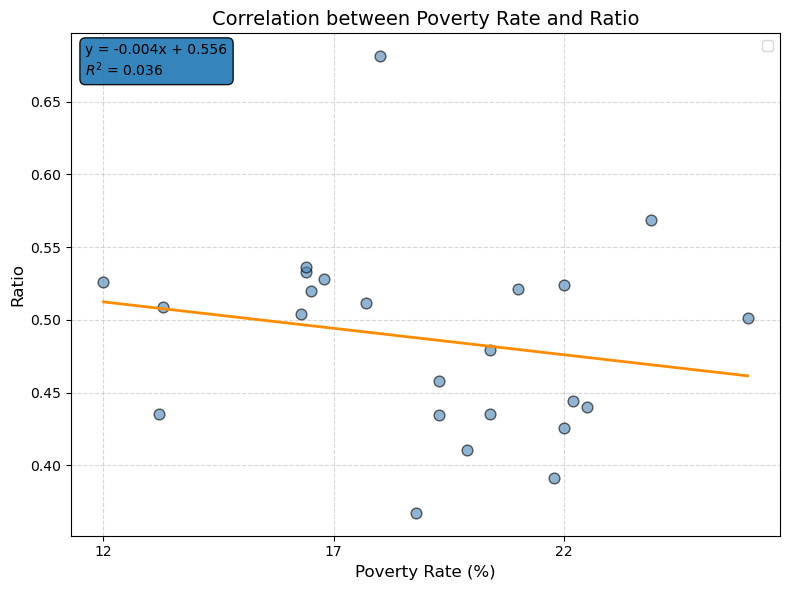

Slope: -0.0036
Intercept: 0.5560


In [297]:
# Drop NAs and ensure numeric
df_clean = df_loan_merged_ratio_avg_1.copy()
df_clean["all_ages_pov_pct_est"] = pd.to_numeric(
    df_clean["all_ages_pov_pct_est"], errors="coerce"
)
df_clean["ratio"] = pd.to_numeric(df_clean["ratio"], errors="coerce")

# Drop NaN and inf values
df_clean = df_clean.replace([np.inf, -np.inf], np.nan).dropna(
    subset=["ratio", "all_ages_pov_pct_est"]
)

# Extract x and y
x = df_clean["all_ages_pov_pct_est"].values.reshape(-1, 1)
y = df_clean["ratio"].values

# Fit linear regression
model = LinearRegression()
model.fit(x, y)
slope = model.coef_[0]
intercept = model.intercept_
r_squared = model.score(x, y)

# Generate fitted values
x_fit = np.linspace(float(x.min()), float(x.max()), 200).reshape(-1, 1)
y_fit = model.predict(x_fit)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(
    x.ravel(),
    y,
    alpha=0.6,
    s=60,
    edgecolor="black",
    color="steelblue",
    zorder=2,
)
plt.plot(
    x_fit.ravel(),
    y_fit,
    color="darkorange",
    linewidth=2,
    zorder=3,
)

# Labels, ticks, and formatting
plt.title("Correlation between Poverty Rate and Ratio", fontsize=14)
plt.xlabel("Poverty Rate (%)", fontsize=12)
plt.ylabel("Ratio", fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda val, _: f"{val:.2f}"))

x_min, x_max = int(np.floor(x.min())), int(np.ceil(x.max()))
plt.xticks(np.arange(x_min, x_max + 1, 5))

# Add equation + R² as a legend box
eq_text = f"y = {slope:.3f}x + {intercept:.3f}\n$R^2$ = {r_squared:.3f}"
plt.annotate(
    eq_text,
    xy=(0.02, 0.98),
    xycoords="axes fraction",
    fontsize=10,
    verticalalignment="top",
    bbox=dict(boxstyle="round,pad=0.4", alpha=0.9),
)

plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Regression stats
print(f"Slope: {model.coef_[0]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")